<a href="https://colab.research.google.com/github/jxin11/waste-image-classification/blob/main/Waste_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


# Import Libraries

In [ ]:
pip install visualkeras

In [ ]:
pip install helper

In [3]:
import cv2
import glob
import random
import pickle
import visualkeras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import ImageFont
from tensorflow import keras
from keras.utils import np_utils
from collections import Counter, OrderedDict
from sklearn import preprocessing
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import keras.backend as K
from tensorflow.keras import backend
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Optimizer, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                                    Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score

# Read & Store Images

In [4]:
!git clone https://github.com/garythung/trashnet

Cloning into 'trashnet'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 42 (delta 4), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (42/42), done.


In [ ]:
!unzip /content/trashnet/data/dataset-resized.zip

In [6]:
SIZE = 128

filepath = []
images = []
labels = []

# Read & Sort filepath
for folder_path in glob.glob("/content/dataset-resized/*"):
  for img_path in glob.glob(folder_path + "/*.jpg"):
    filepath.append(img_path)
  
filepath.sort()

# Read images & labels
for img_path in filepath:
  label = img_path.split("/")[-2]
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE, SIZE))   # Resize image
  images.append(img)
  labels.append(label)

In [7]:
print("Total no. of images: ", len(images))
print("Total no. of labels: ", len(labels))
print("Total no. of unique labels: ", Counter(labels))

Total no. of images:  2527
Total no. of labels:  2527
Total no. of unique labels:  Counter({'paper': 594, 'glass': 501, 'plastic': 482, 'metal': 410, 'cardboard': 403, 'trash': 137})


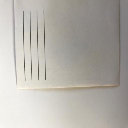

paper


In [8]:
i = 1327
cv2_imshow(images[i])
print(labels[i])

# Prepare Train & Test Sets

In [9]:
# Shuffle images
temp = list(zip(images, labels))
random.Random(0).shuffle(temp)
res1, res2 = zip(*temp)
images, labels = list(res1), list(res2)

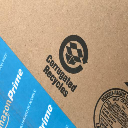

cardboard


In [ ]:
i = 1327
cv2_imshow(images[i])
print(labels[i])

In [157]:
# Train test split
img_train, img_test, label_train, label_test = train_test_split(images, labels, stratify=labels, test_size=0.2, random_state=178)  # 132

In [ ]:
print(len(img_train))
print(len(img_test))

2021
506


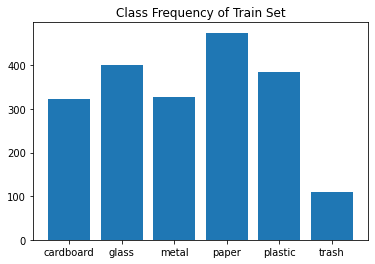


Train Set
cardboard: 322 (15.93%)
glass: 401 (19.84%)
metal: 328 (16.23%)
paper: 475 (23.5%)
plastic: 385 (19.05%)
trash: 110 (5.44%)


In [ ]:
# Plot Class Freqeuncy of Train Set
c_train = OrderedDict(sorted(Counter(label_train).items()))
plt.bar(c_train.keys(), c_train.values())
plt.title("Class Frequency of Train Set")
plt.show()

print("\nTrain Set")
for i, v in enumerate(c_train):
  print(f"{v}: {c_train[v]} ({round(c_train[v]/sum(c_train.values())*100,2)}%)")

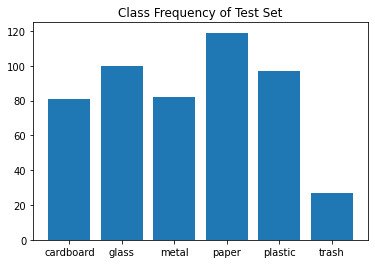


Test Set
cardboard: 81 (16.01%)
glass: 100 (19.76%)
metal: 82 (16.21%)
paper: 119 (23.52%)
plastic: 97 (19.17%)
trash: 27 (5.34%)


In [ ]:
# Plot Class Freqeuncy of Train Set
c_test = OrderedDict(sorted(Counter(label_test).items()))
plt.bar(c_test.keys(), c_test.values())
plt.title("Class Frequency of Test Set")
plt.show()

print("\nTest Set")
for i, v in enumerate(c_test):
  print(f"{v}: {c_test[v]} ({round(c_test[v]/sum(c_test.values())*100,2)}%)")

# Convert to numpy array

In [ ]:
# Before conversion
print("X_train: ", "type-", type(img_train), "; size-", len(img_train))
print("y_train: ", "type-", type(label_train), "; size-", len(label_train))

X_train:  type- <class 'list'> ; size- 2021
y_train:  type- <class 'list'> ; size- 2021


In [158]:
img_train = np.array(img_train, dtype="float")
img_test = np.array(img_test, dtype="float")
label_train = np.array(label_train)
label_test = np.array(label_test)

In [ ]:
# After conversion
print("X_train: ", "type-", type(img_train), "; size-", img_train.shape)
print("y_train: ", "type-", type(label_train), "; size-", label_train.shape)

X_train:  type- <class 'numpy.ndarray'> ; size- (2021, 128, 128, 3)
y_train:  type- <class 'numpy.ndarray'> ; size- (2021,)


# Label Encoding

In [159]:
le = preprocessing.LabelEncoder()
le.fit(label_train)

LabelEncoder()

In [160]:
label_encoded_train = le.transform(label_train)
label_encoded_test = le.transform(label_test)

In [ ]:
le.classes_

array(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
      dtype='<U9')

# One Hot Encoding

In [161]:
n_classes = len(le.classes_)

print("Shape before OHE: ", label_encoded_train.shape)

label_encoded_train = np_utils.to_categorical(label_encoded_train,n_classes)
label_encoded_test = np_utils.to_categorical(label_encoded_test,n_classes)

print("Shape after OHE: ", label_encoded_train.shape)

Shape before OHE:  (2021,)
Shape after OHE:  (2021, 6)


# Normalization



In [162]:
img_train, img_test = img_train/255.0, img_test/255.0

# Data Augmentation
Ref: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

Data augmentation is only applied to train set.

In [106]:
datagen = ImageDataGenerator(rotation_range=20, 
                             horizontal_flip=True, vertical_flip=True)
                             #zoom_range=0.2, shear_range=0.2, width_shift_range=0.2, height_shift_range=0.2)

**batch_size in ImageDataGenerator.flow - If you have 1000 images in your dataset and the batch size is defined as 10. Then the "ImageDataGenerator" will produce 10 images in each iteration of the training.

Original Image: 


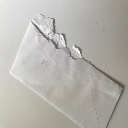


Data Augmentation: 


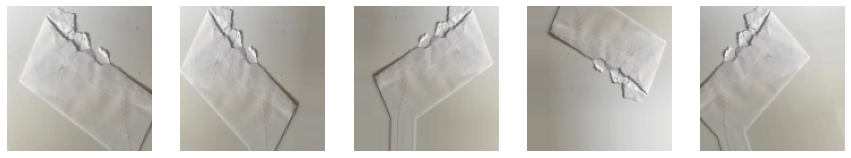

In [ ]:
# Take an image as example

print("Original Image: ")
cv2_imshow(img_train[123]*255)

width, height, channel = img_train.shape[1], img_train.shape[2], img_train.shape[3]
iter = datagen.flow((img_train[123]).reshape(1, width, height, channel), batch_size=1)

# generate samples and plot
print("\nData Augmentation: ")
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

# generate batch of images
for i in range(5):

  image = next(iter)
  image = np.squeeze(image)
  
  # plot image
  ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

# Deep Learning Model Components
Ref: 
1. https://medium.com/the-owl/building-inception-resnet-v2-in-keras-from-scratch-a3546c4d93f0
2. https://arxiv.org/abs/1602.07261

## Convolutional Block

In [55]:
def conv2d(x, filters, kernel_size, strides=1, pad='same', act=True, name=None):
  x = Conv2D(filters=filters, kernel_size=kernel_size,
             strides=strides, padding=pad,
             data_format='channels_last', use_bias=False, 
             name=name+'conv2d')(x)
  x = BatchNormalization(axis=3, scale=False, name=name+'conv2d_bn')(x)
  if act:
    x = Activation('relu', name=name+'conv2d_act')(x)
  return x

Batch Norm reduces the internal covariate shift of the network. <br>
Batch Norm has a regularization effect. <br>
In CNN, each feature map will have a single mean and standard deviation. <br>
The original paper talks about applying batch norm just before the activation function, it has been found in practice that applying batch norm after the activation yields better results. <br>
Ref: 
1. https://www.baeldung.com/cs/batch-normalization-cnn
2. https://blog.paperspace.com/busting-the-myths-about-batch-normalization/

## Inception ResNet A Block

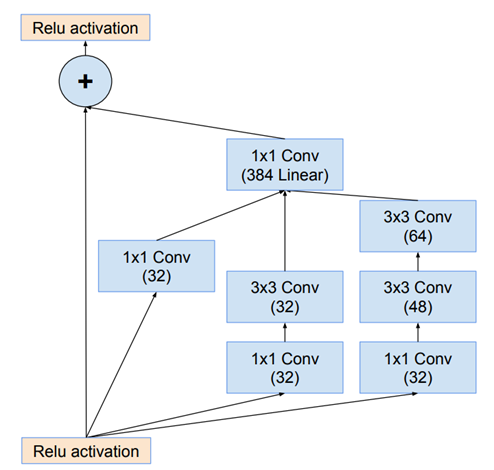

In [56]:
def incResA(x, scale, name=None):

  branch0 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 32, 3, 1, 'same', True, name=name+'b1_2')

  branch2 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, 48, 3, 1, 'same', True, name=name+'b2_2')
  branch2 = conv2d(branch2, 64, 3, 1, 'same', True, name=name+'b2_3')

  branches = [branch0, branch1, branch2]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 384, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Inception ResNet B Block

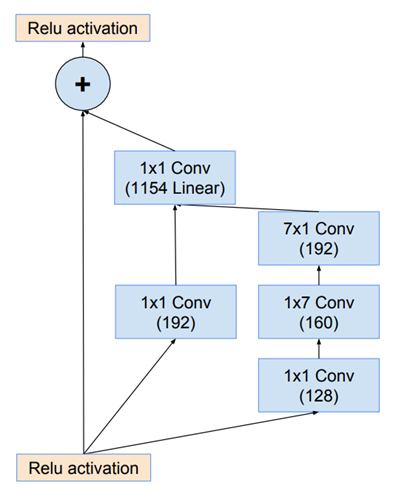

** _filt_exp_1x1 --> from 1154 chg to 1152 filters

In [57]:
def incResB(x, scale, name=None):

  branch0 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 128, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 160, [1,7], 1, 'same', True, name=name+'b1_2')
  branch1 = conv2d(branch1, 192, [7,1], 1, 'same', True, name=name+'b1_3')

  branches = [branch0, branch1]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 1152, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Inception ResNet C Block

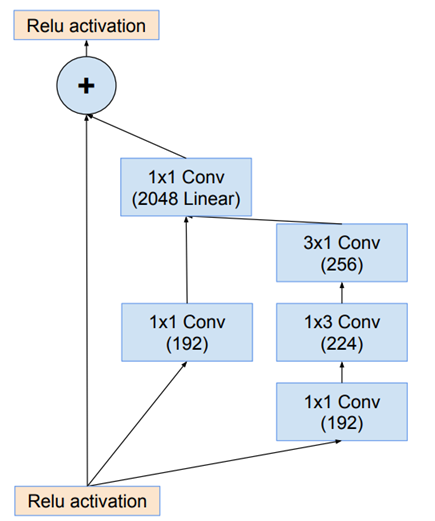

In [58]:
def incResC(x, scale, name=None):

  branch0 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 224, [1,3], 1, 'same', True, name=name+'b1_2')
  branch1 = conv2d(branch1, 256, [3,1], 1, 'same', True, name=name+'b1_3')

  branches = [branch0, branch1]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 2048, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Reduction A Block

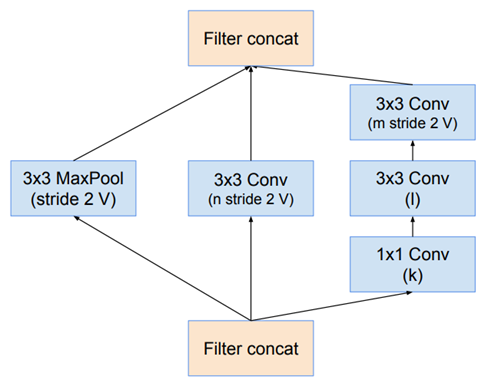

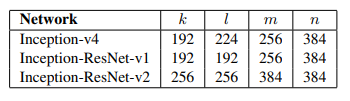

In [59]:
def redA(x, name=None):

  n = 384; k = 256; l = 256; m = 384

  branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

  branch1 = conv2d(x, n, 3, 2, 'valid', True, name=name+'b1')

  branch2 = conv2d(x, k, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, l, 3, 1, 'same', True, name=name+'b2_2')
  branch2 = conv2d(branch2, m, 3, 2, 'valid', True, name=name+'b2_3')

  branches = [branch0, branch1, branch2]
  final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

  return final_lay

## Reduction B Block

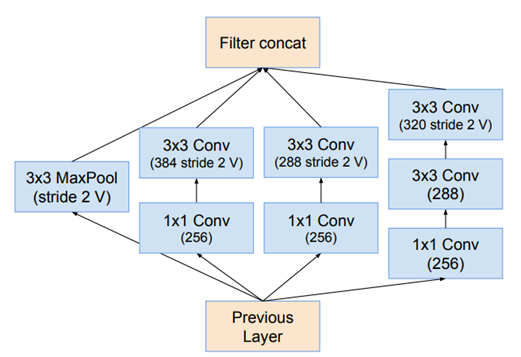

**layers b2_2, b3_2 and b3_3: # kernels --> 256

In [60]:
def redB(x, name=None):

  branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

  branch1 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 384, 3, 2, 'valid', True, name=name+'b1_2')

  branch2 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, 256, 3, 2, 'valid', True, name=name+'b2_2')

  branch3 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b3_1')
  branch3 = conv2d(branch3, 256, 3, 1, 'same', True, name=name+'b3_2')
  branch3 = conv2d(branch3, 256, 3, 2, 'valid', True, name=name+'b3_3')

  branches = [branch0, branch1, branch2, branch3]
  final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

  return final_lay

## Stem Block

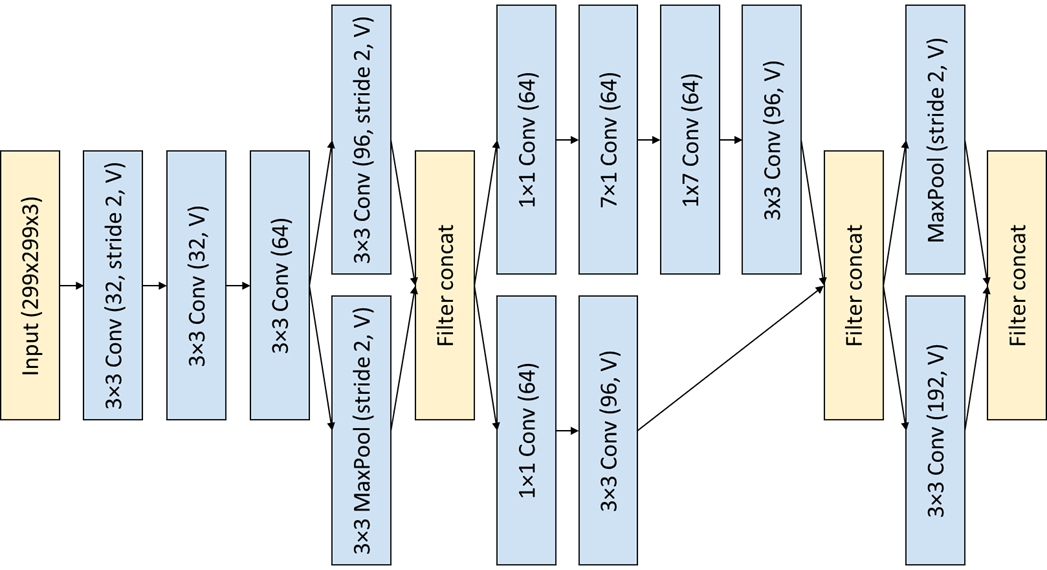

** layer stem_br_32 --> MaxPool, kernel_size = (3,3), stride = 1, 'valid'

In [61]:
def stem(img_input):

  x = conv2d(img_input, 32, 3, 2, 'valid', True, name='conv1')
  x = conv2d(x, 32, 3, 1, 'valid', True, name='conv2')
  x = conv2d(x, 64, 3, 1, 'same', True, name='conv3')
  
  x_11 = MaxPooling2D((3,3), 2, 'valid', name='stem_br_11')(x)
  x_12 = conv2d(x, 96, 3, 2, 'valid', True, name='stem_br_12')
  
  x_1 = [x_11, x_12]
  x = Concatenate(axis=3, name='stem_filt_concat1')(x_1)
  
  x_21 = conv2d(x, 64, 1, 1, 'same', True, name='stem_br_211')
  x_21 = conv2d(x_21, 96, 3, 1, 'valid', True, name='stem_br_212')

  x_22 = conv2d(x, 64, 1, 1, 'same', True, name='stem_br_221')
  x_22 = conv2d(x_22, 64, [7,1], 1, 'same', True, name='stem_br_222')
  x_22 = conv2d(x_22, 64, [1,7], 1, 'same', True, name='stem_br_223')
  x_22 = conv2d(x_22, 96, 3, 1, 'valid', True, name='stem_br_224')

  x_2 = [x_21, x_22]
  x = Concatenate(axis=3, name='stem_filt_concat2')(x_2)
  
  x_31 = conv2d(x, 192, 3, 1, 'valid', True, name='stem_br_31')  # 51 51 192 
  x_32 = MaxPooling2D((3,3), 1, 'valid', name='stem_br_32')(x)   # 27 27 192  26 26 192

  x_3 = [x_31, x_32]
  x = Concatenate(axis=3, name='stem_filt_concat3')(x_3)
  
  return x

# Deep Learning Model - Inception ResNetV2 Model

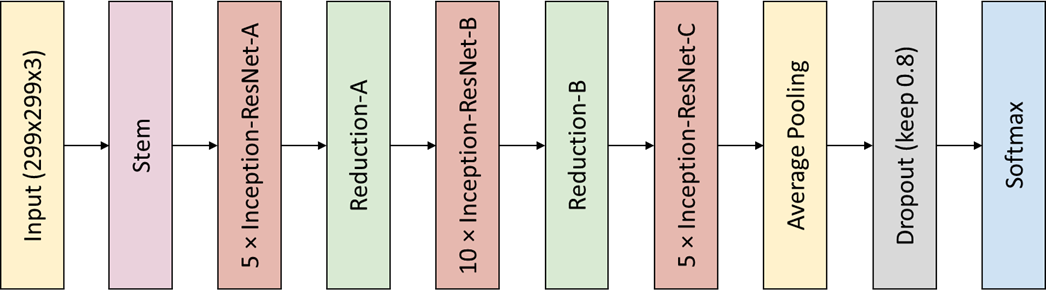

In [165]:
# Base Model

incResA_count = 5
incResB_count = 10
incResC_count = 5

img_input = Input(shape=(SIZE, SIZE, 3))
x = stem(img_input)

for i in range(incResA_count):
  x = incResA(x, 0.15, name='incResA_'+str(i)+'_')
x = redA(x, name='redA_')

for i in range(incResB_count):
  x = incResB(x, 0.1, name='incResB_'+str(i)+'_')
x = redB(x, name='redB_')

for i in range(incResC_count):
  x = incResC(x, 0.2, name='incResC_'+str(i)+'_')

x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dense(128, activation='relu')(x)   #64
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.8)(x)   #0.8
x = Dense(n_classes, activation='softmax')(x)

# Build & Configure Model

Hyperparameter Setting (motivated by other researcher):

* learning rate of 0.045; decayed every two epochs using an
exponential rate of 0.94; reduce 0.1 if loss function does not improve ✅
* Weight initialisation with Gaussian ✅
* Early stopping patience, 10 epochs ✅
* Epochs = 300 ✅
* Mini-batch size = 32 ✅
* Model checkpoint - val_acc ✅
* Baseline - RMSProp with decay/rho of 0.9 and epsilon = 1.0, other  optimizer: Adam, SGD (momentum = 0.9), SGD (momentum = 0.9, Nesterov), GD (momentum = 0.9), AdaGrad ✅

In [164]:
tf.random.set_seed(42)
np.random.seed(128)

In [166]:
base_model = Model(img_input, x, name='inception_resnet_v2')

In [167]:
base_model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.9, epsilon=1.0),   # optimizer=Adam(learning_rate=0.045),#
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

## Early Stopping

In [168]:
early = EarlyStopping(monitor="loss", 
                      mode="min", 
                      patience=10, restore_best_weights=True)

## Reduce LR

In [169]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

## LR Scheduler

In [ ]:
def scheduler(epoch, learning_rate):
  if epoch % 2 != 0 or epoch == 0:
    return learning_rate
  else:
    return learning_rate * tf.math.exp(-0.94)

In [ ]:
scheduler(0, 0.001)

0.001

In [ ]:
scheduler(2, 0.001).numpy()

0.00039062786

In [ ]:
lr_scheduler = LearningRateScheduler(scheduler)

## Model Checkpoint

In [154]:
filepath = "base_model3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

## Callbacks

In [170]:
# callbacks_list = [early, reduce_lr, lr_scheduler, checkpoint]
callbacks_list = [early, checkpoint, reduce_lr]

# Model Training

In [ ]:
# chg train_test_split random_state, w/o reduce_lr
history = base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=32), 
                         epochs=100,
                         steps_per_epoch=img_train.shape[0]//32,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.5335 - accuracy: 0.4032
Epoch 1: val_accuracy improved from -inf to 0.16206, saving model to base_model3.h5
63/63 [==============================] - 52s 448ms/step - loss: 1.5335 - accuracy: 0.4032 - val_loss: 1.7735 - val_accuracy: 0.1621
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 1.3393 - accuracy: 0.4756
Epoch 2: val_accuracy did not improve from 0.16206
63/63 [==============================] - 25s 389ms/step - loss: 1.3393 - accuracy: 0.4756 - val_loss: 1.7630 - val_accuracy: 0.1542
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 1.2654 - accuracy: 0.5239
Epoch 3: val_accuracy improved from 0.16206 to 0.24308, saving model to base_model3.h5
63/63 [==============================] - 25s 401ms/step - loss: 1.2654 - accuracy: 0.5239 - val_loss: 1.7482 - val_accuracy: 0.2431
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 1.2100 - accuracy: 0.5485
Ep

In [ ]:
# include reduce_lr --> check if the convergence rate increase
history = base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=32), 
                         epochs=100,
                         steps_per_epoch=img_train.shape[0]//32,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.6407 - accuracy: 0.3831
Epoch 1: val_accuracy improved from -inf to 0.23518, saving model to base_model3.h5
63/63 [==============================] - 66s 460ms/step - loss: 1.6407 - accuracy: 0.3831 - val_loss: 1.8023 - val_accuracy: 0.2352 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 1.3463 - accuracy: 0.4967
Epoch 2: val_accuracy improved from 0.23518 to 0.30040, saving model to base_model3.h5
63/63 [==============================] - 24s 379ms/step - loss: 1.3463 - accuracy: 0.4967 - val_loss: 1.7927 - val_accuracy: 0.3004 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 1.2651 - accuracy: 0.5359
Epoch 3: val_accuracy did not improve from 0.30040
63/63 [==============================] - 23s 366ms/step - loss: 1.2651 - accuracy: 0.5359 - val_loss: 1.7967 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - ETA: 

In [84]:
img_test.shape

(506, 128, 128, 3)

In [85]:
label_encoded_test.shape

(506, 6)

In [113]:
# alter data aug
history = base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=32), 
                         epochs=20,
                         #steps_per_epoch=img_train.shape[0]//32,
                         validation_data=(img_test, label_encoded_test))
                         #callbacks=callbacks_list)

Epoch 1/20
64/64 [==============================] - 43s 402ms/step - loss: 1.5446 - accuracy: 0.4082 - val_loss: 1.7834 - val_accuracy: 0.1601
Epoch 2/20
64/64 [==============================] - 24s 381ms/step - loss: 1.2869 - accuracy: 0.5186 - val_loss: 1.7994 - val_accuracy: 0.1601
Epoch 3/20
64/64 [==============================] - 25s 389ms/step - loss: 1.2080 - accuracy: 0.5562 - val_loss: 1.7949 - val_accuracy: 0.1621
Epoch 4/20
64/64 [==============================] - 24s 371ms/step - loss: 1.1275 - accuracy: 0.6007 - val_loss: 1.7628 - val_accuracy: 0.2352
Epoch 5/20
64/64 [==============================] - 24s 380ms/step - loss: 1.0923 - accuracy: 0.6002 - val_loss: 1.7502 - val_accuracy: 0.2925
Epoch 6/20
64/64 [==============================] - 24s 376ms/step - loss: 1.0404 - accuracy: 0.6239 - val_loss: 1.6482 - val_accuracy: 0.3439
Epoch 7/20
64/64 [==============================] - 24s 374ms/step - loss: 0.9951 - accuracy: 0.6343 - val_loss: 1.5175 - val_accuracy: 0.3676

In [171]:
# without datagen
# history = base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=32), 
#                          epochs=20,
#                          steps_per_epoch=img_train.shape[0]//32,
#                          validation_data=(img_test, label_encoded_test),
#                          callbacks=callbacks_list)

history = base_model.fit(img_train, label_encoded_train, batch_size=32, 
                         epochs=50,
                         steps_per_epoch=img_train.shape[0]//32,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 1.5388 - accuracy: 0.4246
Epoch 1: val_accuracy did not improve from 0.76482
63/63 [==============================] - 43s 406ms/step - loss: 1.5388 - accuracy: 0.4246 - val_loss: 1.7751 - val_accuracy: 0.2352 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 1.2620 - accuracy: 0.5344
Epoch 2: val_accuracy did not improve from 0.76482
63/63 [==============================] - 24s 379ms/step - loss: 1.2620 - accuracy: 0.5344 - val_loss: 1.7989 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 1.1790 - accuracy: 0.5626
Epoch 3: val_accuracy did not improve from 0.76482
63/63 [==============================] - 24s 381ms/step - loss: 1.1790 - accuracy: 0.5626 - val_loss: 1.7838 - val_accuracy: 0.3063 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.6214
Epoch 4: val_accuracy did not improv

In [ ]:
history = base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=32), 
                         epochs=100,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 2.2617 - accuracy: 0.4488
Epoch 1: val_accuracy improved from 0.24506 to 0.43083, saving model to base_model.h5
64/64 [==============================] - 95s 440ms/step - loss: 2.2617 - accuracy: 0.4488 - val_loss: 1.7919 - val_accuracy: 0.4308 - lr: 0.0450
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 1.9474 - accuracy: 0.4963
Epoch 2: val_accuracy improved from 0.43083 to 0.49209, saving model to base_model.h5
64/64 [==============================] - 26s 402ms/step - loss: 1.9474 - accuracy: 0.4963 - val_loss: 1.3017 - val_accuracy: 0.4921 - lr: 0.0450
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 1.7986 - accuracy: 0.5314
Epoch 3: val_accuracy did not improve from 0.49209
64/64 [==============================] - 24s 377ms/step - loss: 1.7986 - accuracy: 0.5314 - val_loss: 1.4890 - val_accuracy: 0.4802 - lr: 0.0176
Epoch 4/100
64/64 [==============================] - ETA:

# Save Model & History

## Save & Load Training History

In [ ]:
import pickle
with open('trainHistoryDict', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [ ]:
# load
history = pickle.load(open('trainHistoryDict', "rb"))

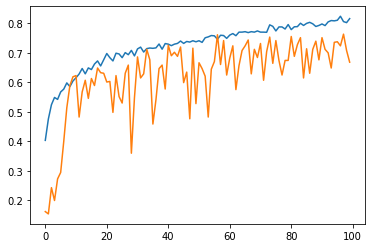

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])

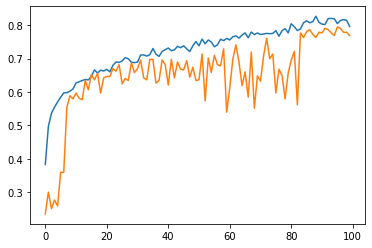

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])

## Save & Load Model

In [ ]:
#make sure to load the best model
model.load_weights('model.h5')

predictions = model.predict_generator(test_gen, 
                                      steps=num_test_images, 
                                      verbose=1)

# Evaluation